In [86]:
import ezdxf

doc = ezdxf.readfile("../tracks/vivatech_2023.dxf")

In [87]:
msp = doc.modelspace()

In [10]:
count = {}
for e in msp:
    count[type(e)] = count.get(type(e),0)+1
print(count)

{<class 'ezdxf.entities.line.Line'>: 36, <class 'ezdxf.entities.arc.Arc'>: 24}


In [91]:
import numpy as np
import shapely.geometry as geom


def discretize_arc(center, radius, start_angle, end_angle, num_segments=1000):
    # https://stackoverflow.com/questions/30762329/how-to-create-polygons-with-arcs-in-shapely-or-a-better-library
    centerx, centery = center

    # The coordinates of the arc
    theta = np.radians(np.linspace(start_angle, end_angle, num_segments))
    x = centerx + radius * np.cos(theta)
    y = centery + radius * np.sin(theta)

    return np.column_stack([x, y])


def dxf_arc_to_points(dxf_entity):
    d = dxf_entity.dxf
    x = d.center.x
    y = d.center.y
    return discretize_arc(
        center = (x, y),
        radius=d.radius,
        start_angle=d.start_angle,
        end_angle=d.end_angle,
    )


def dxf_line_to_points(dxf_entity):
    start = dxf_entity.dxf.start
    end = dxf_entity.dxf.end
    return np.array([[start.x, start.y], [end.x, end.y]])


def dxf_to_points(dxf_entity):
    if isinstance(dxf_entity, ezdxf.entities.Line):
        return dxf_line_to_points(dxf_entity)
    elif isinstance(dxf_entity, ezdxf.entities.Arc):
        return dxf_arc_to_points(dxf_entity)


def sort_shapes(elements):
    """
        takes in a list of ezdxf lines and arcs
        seperate out the inner, center, outer lines
        return shapely linearrings
    """
    shapes = []
    current_shape = None

    def get_start(dxf_entity):
        if isinstance(dxf_entity, ezdxf.entities.Arc):
            return dxf_entity.start_point
        if isinstance(dxf_entity, ezdxf.entities.Line):
            return dxf_entity.dxf.start

    def get_end(dxf_entity):
        if isinstance(dxf_entity, ezdxf.entities.Arc):
            return dxf_entity.end_point
        if isinstance(dxf_entity, ezdxf.entities.Line):
            return dxf_entity.dxf.end

    def find_next(last_point):
        for i, element in enumerate(elements):
            # get both end of the line/arc
            start = get_start(element)
            end = get_end(element)
            start = np.array([start.x, start.y])
            end = np.array([end.x, end.y])

            if np.isclose(start, last_point, atol=1e-1).all():
                return (i, dxf_to_points(element))
            elif np.isclose(end, last_point, atol=1e-1).all(): # reversed
                points = dxf_to_points(element)
                return (i, np.flip(points, axis=0))

        print("can't find next, impossible bc closed shapes")
        return None

    while elements: # while we havent processed all elements
        if current_shape is None: # if we haven't started processing a shape
            # take a random element, convert to points, put it in the shape
            current_shape = dxf_to_points(elements.pop(0))
        else: # if we started
            idx, next = find_next(current_shape[-1])
            current_shape = np.concatenate([current_shape, next], axis=0)
            del elements[idx]

            # check if the shape is closed
            if np.isclose(current_shape[0], current_shape[-1], atol=1e-1).all():
                shapes.append(geom.LinearRing(current_shape))
                current_shape = None

    return shapes

sorted_shapes = sort_shapes(list(msp))
len(sorted_shapes)

3

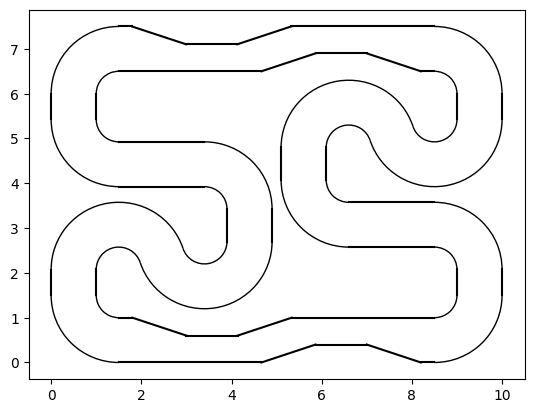

In [39]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

def plot_shape(msp):
    for e in msp:
        if type(e) == ezdxf.entities.Arc:
            d = e.dxf
            x = d.center.x
            y = d.center.y
            width = d.radius*2
            start_angle = d.start_angle
            end_angle = d.end_angle
            arc = Arc((x, y), width, width, angle=0, theta1=start_angle, theta2=end_angle, color='k')
            plt.gca().add_patch(arc)
        if type(e) == ezdxf.entities.Line:
            start = e.dxf.start
            end = e.dxf.end
            plt.plot([start.x, end.x], [start.y, end.y], 'k-') 
    plt.show() 

plot_shape(msp)